# Retention Rate
Retention Rate (удержание клиентов) — это способность компании удерживать своих потребителей в течение определенного периода времени.

Успех в удержании клиентов измеряется показателем Retention Rate (коэффициент удержания клиентов). По сути он является противоположностью Churn Rate (показатель оттока клиентов)

In [23]:
import pandahouse as ph
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
connection = {'host': 'http://clickhouse.beslan.pro:8080/',
                      'user':'student', 
                      'password':'dpo_python_2020'
              }

Посчитаем Retention Rate на данных пользователей мобильного приложения.

In [3]:
query = """
    SELECT
      DaysDistance
      , uniqExact(DeviceID) AS Devices
    FROM (
        SELECT
          l.AppPlatform AS Platform
          , l.events AS Events
          , CAST(l.EventDate AS Date) AS EventDate
          , l.DeviceID AS DeviceID
          , r.Birthday AS Birthday
          , CAST(l.EventDate AS Date) - r.Birthday AS DaysDistance
        FROM events as l
        LEFT JOIN (
          SELECT 
            DeviceID
            , MIN(CAST(EventDate AS Date)) AS Birthday
          FROM events
          WHERE AppPlatform == 'iOS'
          GROUP BY DeviceID
          ) AS r
          ON l.DeviceID = r.DeviceID
        WHERE l.AppPlatform == 'iOS'
        )
    GROUP BY DaysDistance
    ORDER BY DaysDistance ASC
"""

In [4]:
retention = ph.read_clickhouse(query=query, connection=connection)

In [7]:
retention.head()

,DaysDistance,Devices
0,0,4298120
1,1,910022
2,2,715545
3,3,640871
4,4,603138


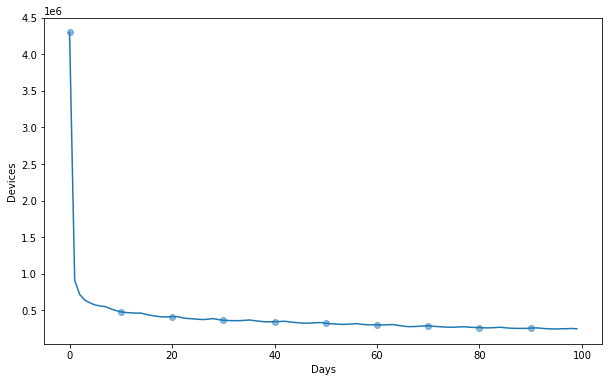

In [19]:
retention_100 = retention.head(100) # select first 100 days after zero-day
plt.subplots(figsize=(10,6))
plt.plot(retention_100.DaysDistance, retention_100.Devices)
plt.scatter(retention_100.DaysDistance[::10], retention_100.Devices[::10], alpha=.5)
plt.xlabel('Days')
plt.ylabel('Devices');

Возьмем `Birthday` в качестве базы для формирования когорт.

In [20]:
query = """
    SELECT
      Cohort
      , DaysDistance
      , uniqExact(DeviceID) AS Devices

    FROM (
        SELECT
          l.AppPlatform AS Platform
          , l.events AS Events
          , CAST(l.EventDate AS Date) AS EventDate
          , l.DeviceID AS DeviceID
          , r.Birthday AS Birthday
          , CAST(l.EventDate AS Date) - r.Birthday AS DaysDistance
        FROM events as l
        LEFT JOIN (
          SELECT 
            DeviceID
            , MIN(CAST(EventDate AS Date)) AS Birthday
          FROM events
          WHERE AppPlatform == 'iOS'
          GROUP BY DeviceID
        ) AS r
          ON l.DeviceID = r.DeviceID
        WHERE l.AppPlatform == 'iOS'
      )
    WHERE DaysDistance <= 10 AND Birthday >= CAST('2019-09-25' AS Date)
    GROUP BY Birthday AS Cohort, DaysDistance
    ORDER BY Cohort DESC, DaysDistance DESC
    LIMIT 1000
"""

Интерфейс tabix в clickhouse позволяет рисовать собственные heatmap

`DRAW_HEATMAP
'DaysDistance.Cohort.Devices'`

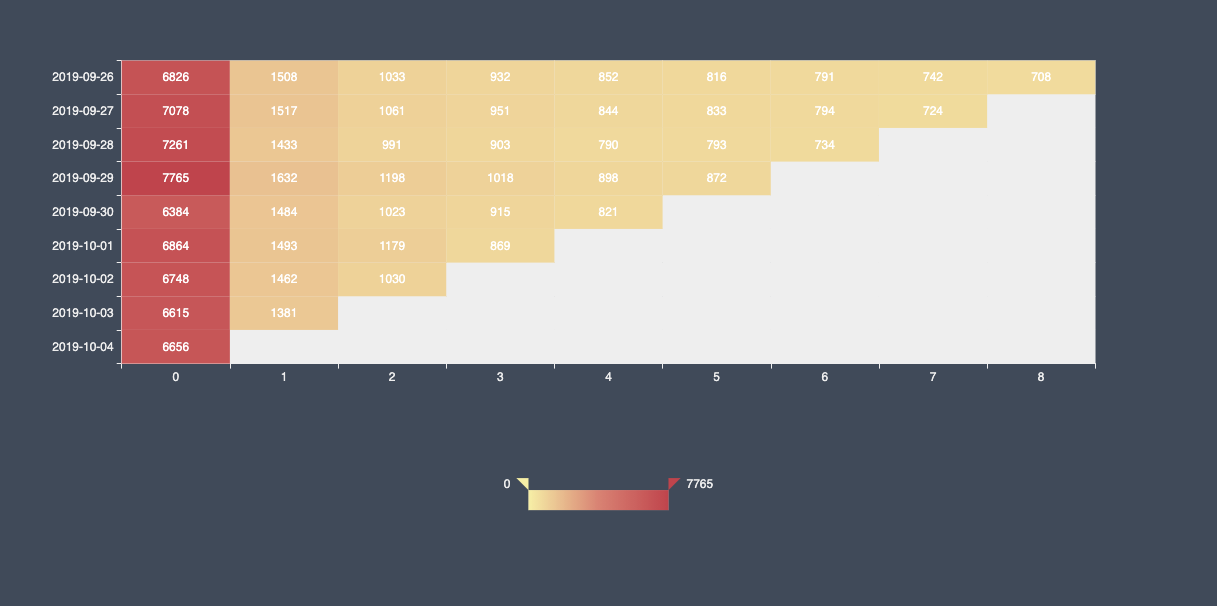

In [21]:
cohort = ph.read_clickhouse(query=query, connection=connection)

In [22]:
cohort.head()

,Cohort,DaysDistance,Devices
0,2019-10-04,0,6656
1,2019-10-03,1,1381
2,2019-10-03,0,6615
3,2019-10-02,2,1030
4,2019-10-02,1,1462


In [34]:
cohort_table = cohort.pivot(index='Cohort', columns='DaysDistance', values='Devices')

In [42]:
cohort_table

DaysDistance,0,1,2,3,4,5,6,7,8,9
Cohort,,,,,,,,,,
2019-09-25,7009.0,1655.0,1224.0,973.0,894.0,874.0,826.0,767.0,736.0,664.0
2019-09-26,6826.0,1508.0,1033.0,932.0,852.0,816.0,791.0,742.0,708.0,NaN
2019-09-27,7078.0,1517.0,1061.0,951.0,844.0,833.0,794.0,724.0,NaN,NaN
2019-09-28,7261.0,1433.0,991.0,903.0,790.0,793.0,734.0,NaN,NaN,NaN
2019-09-29,7765.0,1632.0,1198.0,1018.0,898.0,872.0,NaN,NaN,NaN,NaN
2019-09-30,6384.0,1484.0,1023.0,915.0,821.0,NaN,NaN,NaN,NaN,NaN
2019-10-01,6864.0,1493.0,1179.0,869.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-02,6748.0,1462.0,1030.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-03,6615.0,1381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


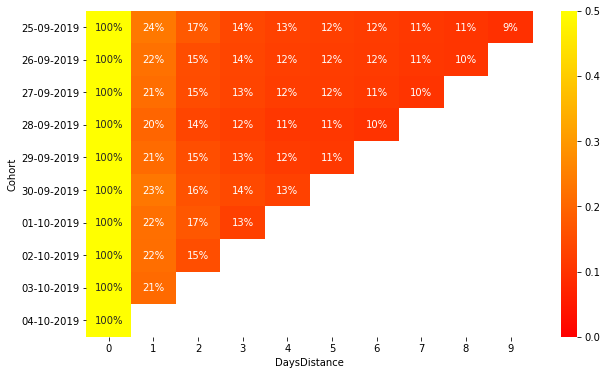

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(data=cohort_table.divide(cohort_table.iloc[:, 0], axis=0),
                        annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap="autumn")
ax.set_yticklabels([x.date().strftime("%d-%m-%Y") for x in cohort_table.index], ha='right');